## Ejercicios de pair programming 26 enero: Decision Tree

In [1]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

### Info columnas
|Columna| Tipo de dato | Descripcion |
|-------|--------------|-------------|
|Region| String|	Name of the region.
|WRI	| Decimal |	World Risk Score of the region.
|Exposure	| Decimal |	Risk/exposure to natural hazards such as earthquakes, hurricanes, floods, droughts, and sea ​​level rise.
|Vulnerability	| Decimal |	Vulnerability depending on infrastructure, nutrition, housing situation, and economic framework conditions.
|Susceptibility	| Decimal |	Susceptibility depending on infrastructure, nutrition, housing situation, and economic framework conditions.
|Lack of Coping Capabilities	| Decimal |	Coping capacities in dependence of governance, preparedness and early warning, medical care, and social and material security.
|Lack of Adaptive Capacities| Decimal |	Adaptive capacities related to coming natural events, climate change, and other challenges.
|Year	| Decimal |	Year data is being described.
|WRI Category| String|	WRI Category for the given WRI Score.
|Exposure Category| String|	Exposure Category for the given Exposure Score.
|Vulnerability Categoy| String|	Vulnerability Category for the given Vulnerability Score.
|Susceptibility Category| String|	Susceptibility Category for the given Susceptibility Score.

Link a la base de datos : https://www.kaggle.com/datasets/tr1gg3rtrash/global-disaster-risk-index-time-series-dataset

### Nuestra variable respuesta es Exposure_Sklearn, queremos saber cual es el riesgo de desastres naturales dependiendo del resto de variables



---

### df limpio

---

In [2]:
df = pd.read_csv("../datos/encoding.csv", index_col = 0)
df.head(2)

,region,wri_category,vulnerability_category,susceptibility_category,wri,exposure,vulnerability,susceptibility,lack_of_coping_capabilities,lack_of_adaptive_capacities,year,exposure_Sklearn,wri_categorymap,susceptibility_categorymap,vulnerability_categorymap
0,papua new guinea,Very High,Very High,Very High,2.906480,23.26,1.296928,1.179006,0.962932,1.537045,2011.0,0.895683,5,5,5
1,madagascar,Very High,Very High,Very High,2.594391,20.68,1.545395,2.260942,1.017385,0.974085,2011.0,0.792566,5,5,5


In [3]:
#Definimos x, eliminamos las variables categóricas y la variable respuesta y la y con la variable respuesta
X = df.drop(['region','wri_category','vulnerability_category', 'susceptibility_category', 'exposure', 'exposure_Sklearn' ], axis = 1)
y = df["exposure_Sklearn"]

In [4]:
#Vamos a dividir nuestras variables de train y test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [5]:
arbol = DecisionTreeRegressor(random_state =0)

arbol.fit(x_train, y_train)

DecisionTreeRegressor(random_state=0)

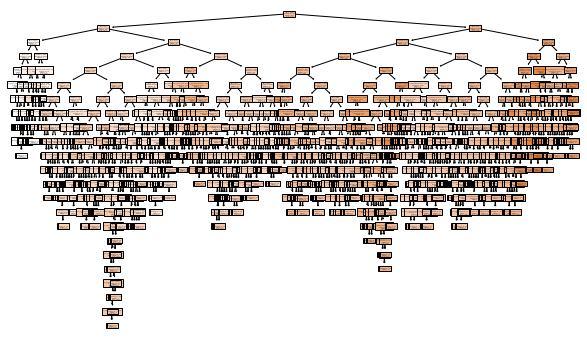

In [6]:
#Representamos nuestro primer arbol
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train.columns, filled = True)
plt.show()

Vemos que nuestro *decision tree* es *overfitting* por lo cual probaremos los diferentes hiperparámetros. 

In [7]:
#Vemos cual es nuestro max_features
max_features = np.sqrt(len(x_train.columns))
max_features

3.0

Nos quedamos con 3

In [8]:
# Vemos nuestra profundidaad de 22
print(arbol.tree_.max_depth)

22


In [9]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = arbol.predict(x_test)
y_pred_train_dt = arbol.predict(x_train)

In [10]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    resultados = {'MAE': [mean_absolute_error(y_test, y_test_pred), mean_absolute_error(y_train, y_train_pred)],
                'MSE': [mean_squared_error(y_test, y_test_pred), mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(mean_squared_error(y_test, y_test_pred)), np.sqrt(mean_squared_error(y_train, y_train_pred))],
                'R2':  [r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [11]:
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,1.222881e-02,5.454194e-04,2.335422e-02,0.982917,test,Decission Tree I
1,2.706372e-18,2.287395e-34,1.512414e-17,1.000000,train,Decission Tree I


El modelo está *overfitting* por lo cual decidimos reducir la profundidad y el *max_features*

In [12]:
df.shape

(1706, 15)

In [13]:
param = {"max_depth": [2,4,9], # la profundidad de nuestro arbol es de 22 por lo cual nos quedamos con 9 y 2 valores mas pequeños.
        "max_features": [1,2,3], # hemos calculado la raiz cuadrada de las variablñes predictoras y era 3,2 así que nos quedamos con 3 como maximo
        "min_samples_split": [10, 50, 100], #hemos calculado el numero de filas de nuestro fichero, 1706, por lo cual nos quedamos con un 100 como maximo.
        "min_samples_leaf": [10,50,100]} 

In [14]:
gs = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param,
            cv=10, 
            verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [15]:
gs.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 9], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [16]:
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeRegressor(max_depth=9, max_features=3, min_samples_leaf=10,
                      min_samples_split=50)

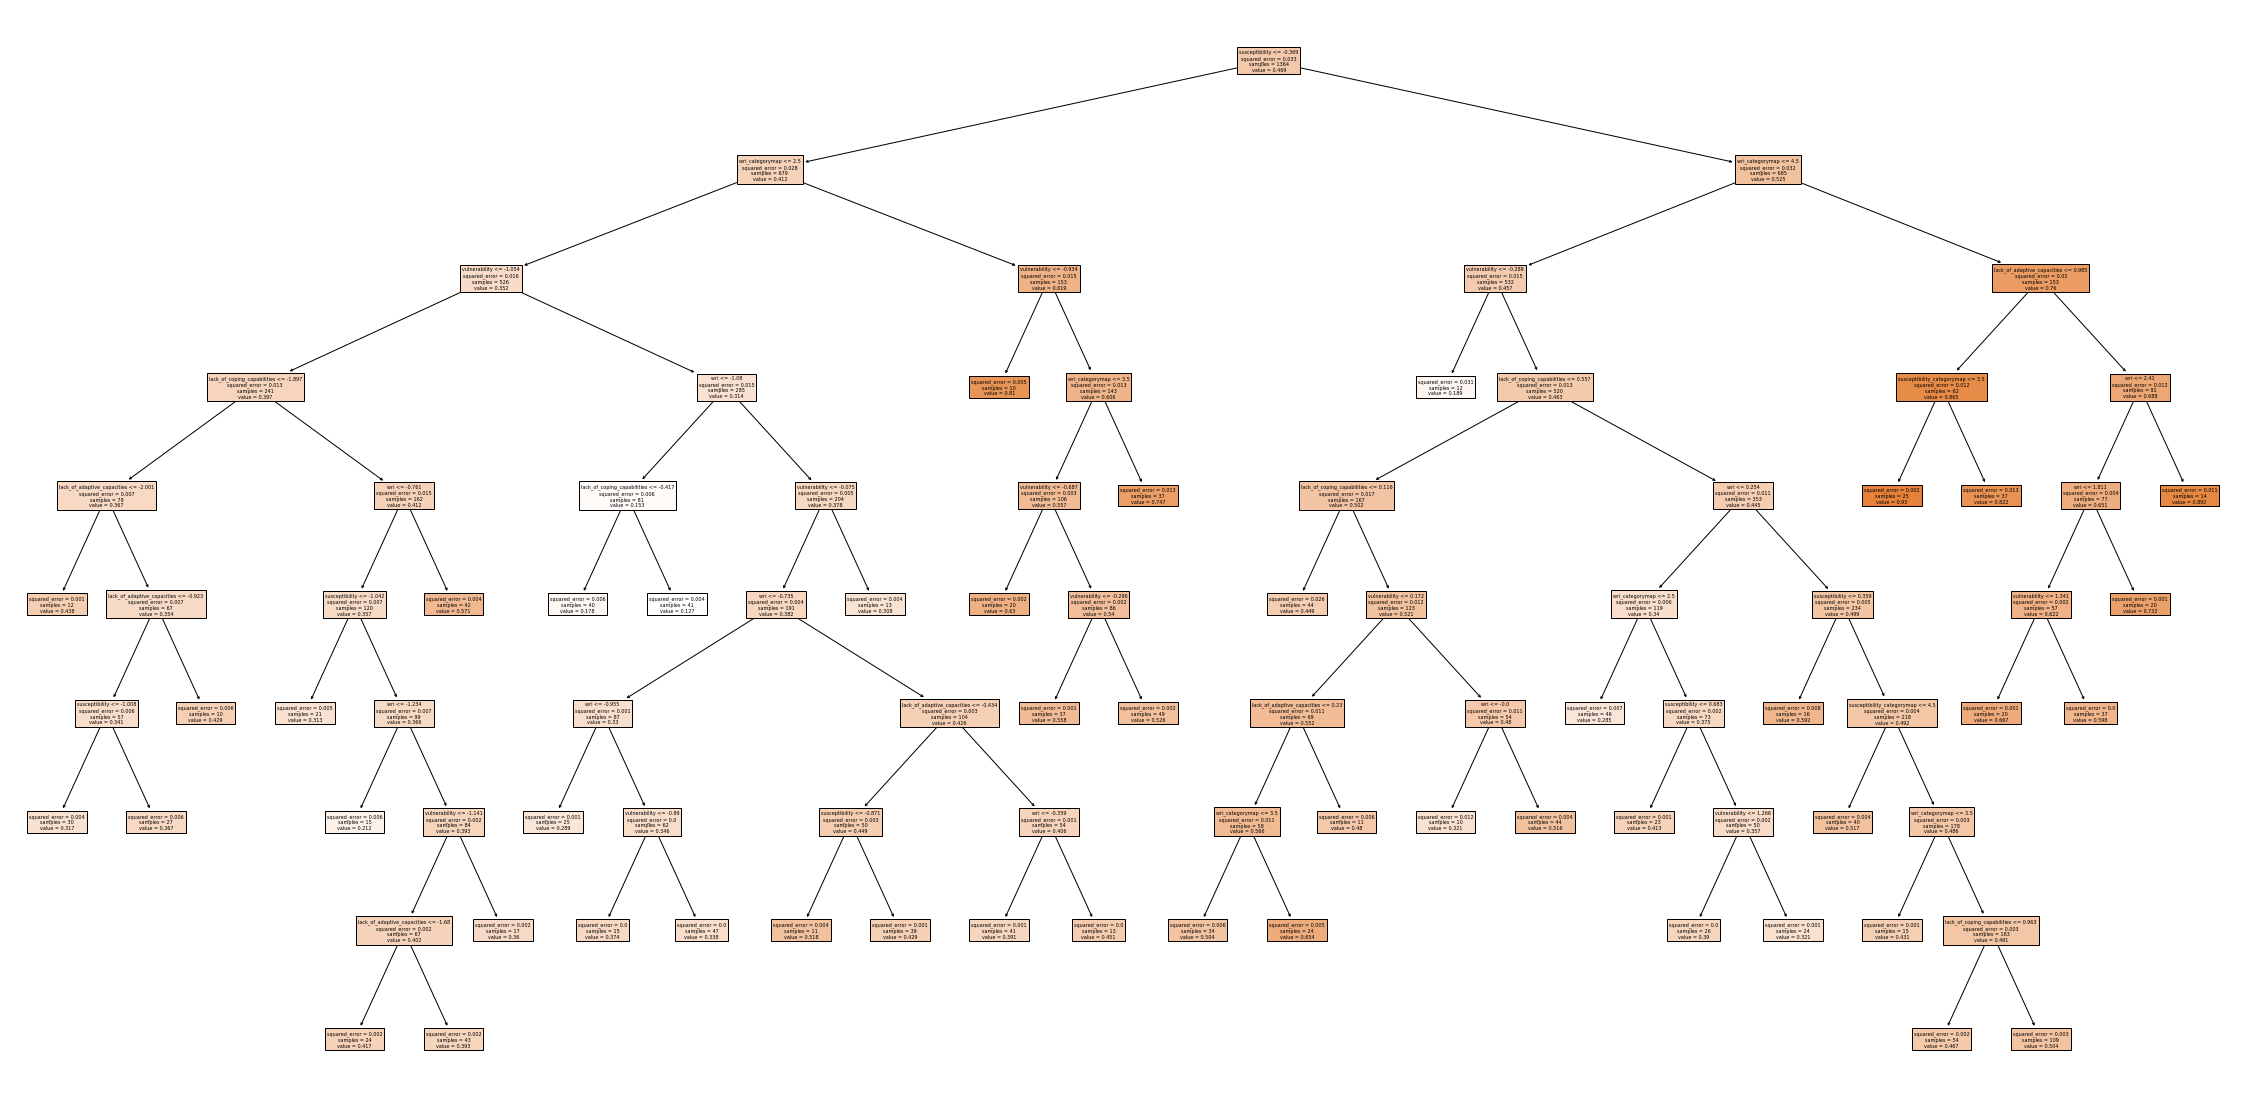

In [17]:
fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train.columns, filled=True);

In [18]:
y_pred_test_dt2 = mejor_modelo.predict(x_test)
y_pred_train_dt2 = mejor_modelo.predict(x_train)

In [19]:
#Vemos las métricas de nuestro segundo decision tree
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,0.055336,0.005948,0.077121,0.813708,test,Decision tree II
1,0.048097,0.004621,0.067976,0.861464,train,Decision tree II


In [20]:
df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,1.222881e-02,5.454194e-04,2.335422e-02,0.982917,test,Decission Tree I
1,2.706372e-18,2.287395e-34,1.512414e-17,1.000000,train,Decission Tree I
0,5.533644e-02,5.947724e-03,7.712149e-02,0.813708,test,Decision tree II
1,4.809687e-02,4.620704e-03,6.797576e-02,0.861464,train,Decision tree II


Nuestro modelo sigue estando bastante *overfiting* por lo que no consideramos que sea un buen modelo

In [21]:
importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo.feature_importances_}
                            )

# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores


Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
6,wri_categorymap,0.534204
0,wri,0.216532
2,susceptibility,0.119371
1,vulnerability,0.069488
4,lack_of_adaptive_capacities,0.036371
3,lack_of_coping_capabilities,0.018850
7,susceptibility_categorymap,0.005183
5,year,0.000000
8,vulnerability_categorymap,0.000000


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/seaborn/palettes.py:443: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


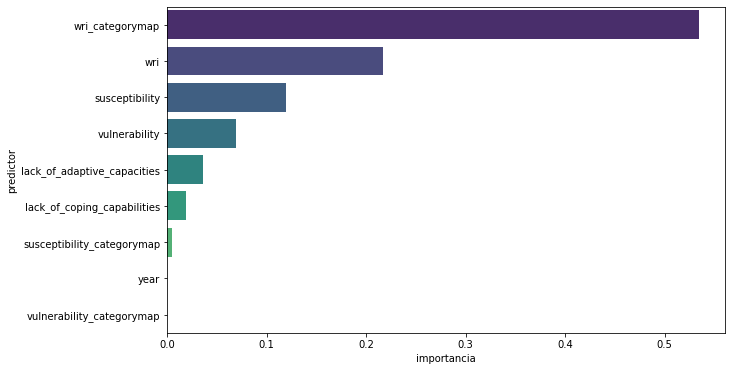

In [22]:
#Representamos para ver la importancia de cada variable
plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

In [23]:
#Volvemos a modificar nuestros hiperparámetros para evitar el overfitting
param_1 = {"max_depth": [5,6,7,8], # hemos cambiado la profundidad de nuestro arbol y hemos puesto 4 posibilidades mas pequeñas de 9.
        "max_features": [1,2,3], # hemos calculado la raiz cuadrada de las variablñes predictoras y era 3,2 así que nos quedamos con 3 como maximo
        "min_samples_split": [10, 50, 100], #hemos calculado el numero de filas de nuestro fichero, 1706, por lo cual nos quedamos con un 100 como maximo.
        "min_samples_leaf": [10,50,100]} 

In [24]:
gs_1 = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param_1,
            cv=10, 
            verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [25]:
gs_1.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [5, 6, 7, 8], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [26]:
mejor_modelo_1 = gs_1.best_estimator_
mejor_modelo_1

DecisionTreeRegressor(max_depth=7, max_features=3, min_samples_leaf=10,
                      min_samples_split=10)

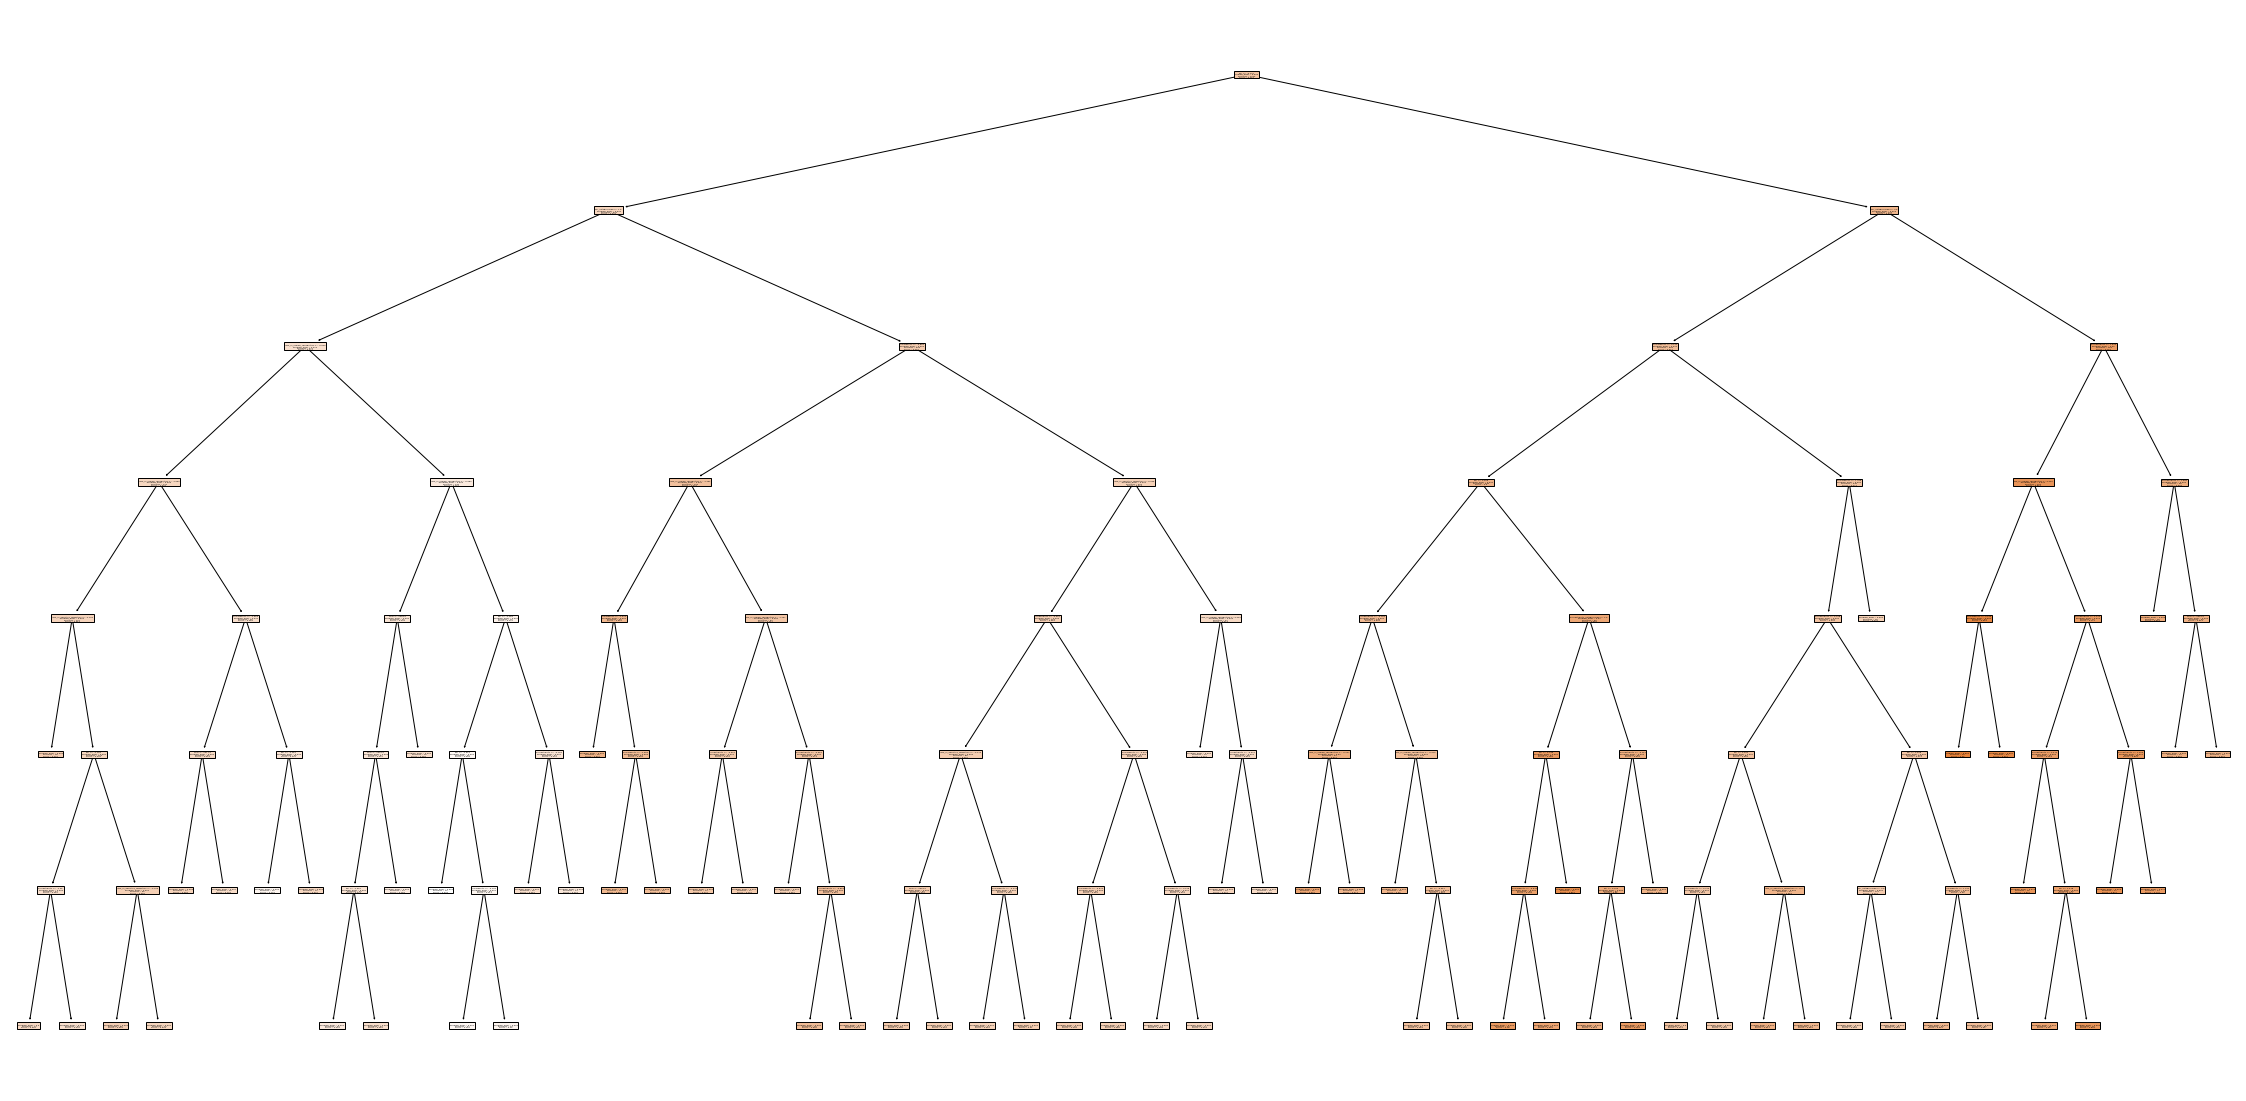

In [27]:
fig_1 = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo_1, feature_names=x_train.columns, filled=True);

In [28]:
y_pred_test_dt3 = mejor_modelo_1.predict(x_test)
y_pred_train_dt3 = mejor_modelo_1.predict(x_train)

In [29]:
#Vemos nuestras métricas del decision tree modficado
dt_results3 = metricas(y_test, y_train, y_pred_test_dt3, y_pred_train_dt3, "Decision tree III")
dt_results3

,MAE,MSE,RMSE,R2,set,modelo
0,0.046019,0.003863,0.062155,0.878998,test,Decision tree III
1,0.039006,0.002799,0.052906,0.916079,train,Decision tree III


In [30]:
df_decision_results = pd.concat([dt_results1, dt_results2,dt_results3], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,1.222881e-02,5.454194e-04,2.335422e-02,0.982917,test,Decission Tree I
1,2.706372e-18,2.287395e-34,1.512414e-17,1.000000,train,Decission Tree I
0,5.533644e-02,5.947724e-03,7.712149e-02,0.813708,test,Decision tree II
1,4.809687e-02,4.620704e-03,6.797576e-02,0.861464,train,Decision tree II
0,4.601923e-02,3.863229e-03,6.215488e-02,0.878998,test,Decision tree III
1,3.900606e-02,2.799081e-03,5.290634e-02,0.916079,train,Decision tree III


El modelo está mas overfitting por lo cual intentamos con otras hiperparametros

In [31]:
param_2 = {"max_depth": [5,6,7,8], # hemos cambiado la profundidad de nuestro arbol y hemos puesto 4 posibilidades mas pequeñas de 9.
        "max_features": [1,2,3], # hemos calculado la raiz cuadrada de las variablñes predictoras y era 3,2 así que nos quedamos con 3 como maximo
        "min_samples_split": [20,50,100], #hemos calculado el numero de filas de nuestro fichero, 1706, por lo cual nos quedamos con un 100 como maximo.
        "min_samples_leaf": [20,50,100]} 

In [32]:
gs_2 = GridSearchCV(
            estimator=DecisionTreeRegressor(), 
            param_grid= param_2,
            cv=10, 
            verbose=-1, 
            return_train_score = True, 
            scoring="neg_mean_squared_error") 

In [33]:
gs_2.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [5, 6, 7, 8], 'max_features': [1, 2, 3],
                         'min_samples_leaf': [20, 50, 100],
                         'min_samples_split': [20, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=-1)

In [34]:
mejor_modelo_2 = gs_2.best_estimator_
mejor_modelo_2

DecisionTreeRegressor(max_depth=8, max_features=3, min_samples_leaf=20,
                      min_samples_split=20)

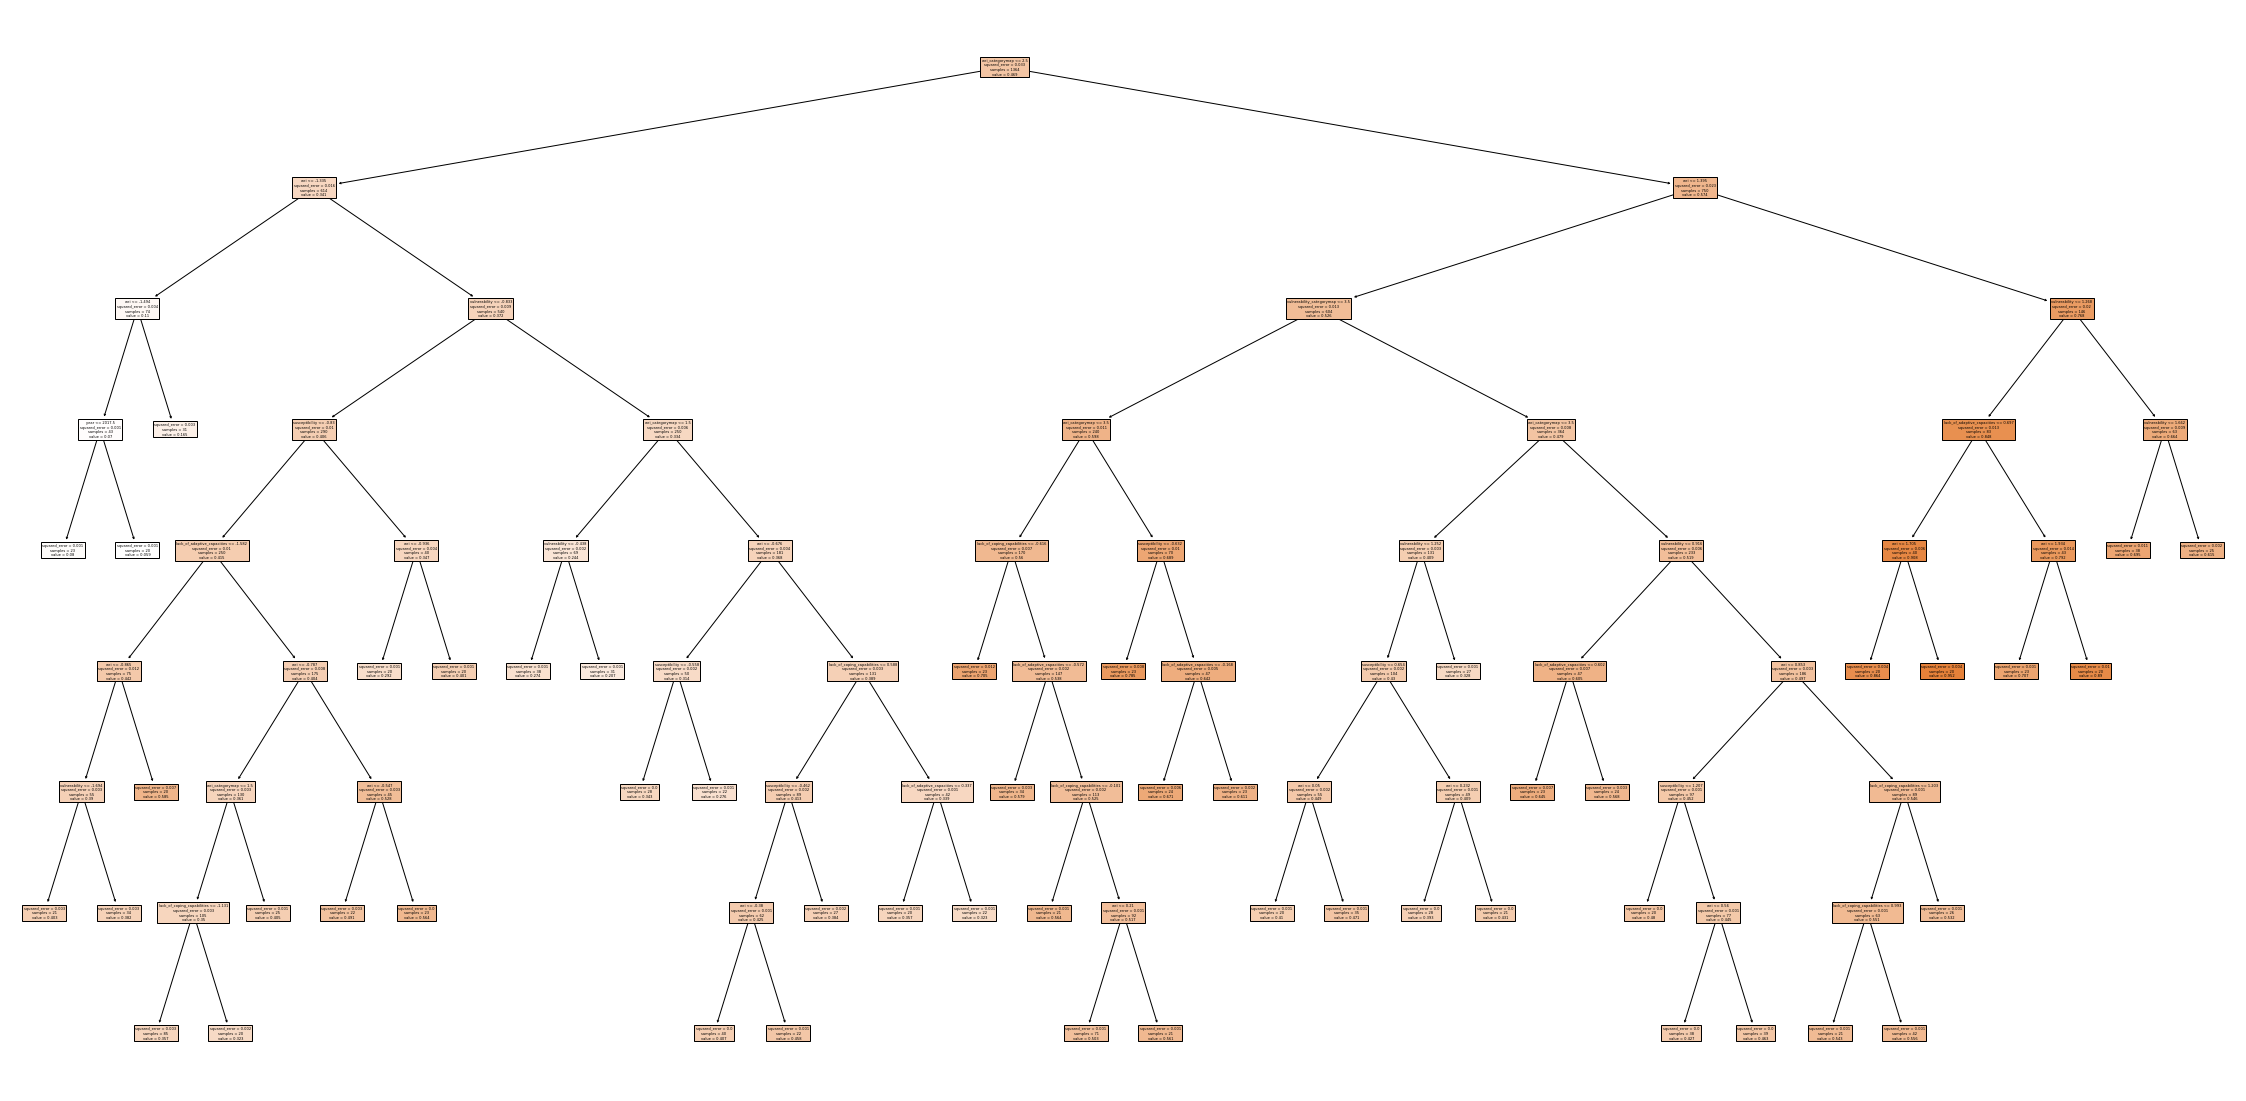

In [35]:
fig_2 = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo_2, feature_names=x_train.columns, filled=True);

In [36]:
y_pred_test_dt4 = mejor_modelo_2.predict(x_test)
y_pred_train_dt4 = mejor_modelo_2.predict(x_train)

In [37]:
dt_results4 = metricas(y_test, y_train, y_pred_test_dt4, y_pred_train_dt4, "Decision tree IV")
dt_results4

,MAE,MSE,RMSE,R2,set,modelo
0,0.043654,0.003284,0.057305,0.897146,test,Decision tree IV
1,0.036365,0.002462,0.049614,0.926198,train,Decision tree IV


In [38]:
df_decision_results = pd.concat([dt_results1, dt_results2,dt_results3,dt_results4], axis = 0)
df_decision_results

,MAE,MSE,RMSE,R2,set,modelo
0,1.222881e-02,5.454194e-04,2.335422e-02,0.982917,test,Decission Tree I
1,2.706372e-18,2.287395e-34,1.512414e-17,1.000000,train,Decission Tree I
0,5.533644e-02,5.947724e-03,7.712149e-02,0.813708,test,Decision tree II
1,4.809687e-02,4.620704e-03,6.797576e-02,0.861464,train,Decision tree II
0,4.601923e-02,3.863229e-03,6.215488e-02,0.878998,test,Decision tree III
1,3.900606e-02,2.799081e-03,5.290634e-02,0.916079,train,Decision tree III
0,4.365406e-02,3.283817e-03,5.730460e-02,0.897146,test,Decision tree IV
1,3.636528e-02,2.461592e-03,4.961443e-02,0.926198,train,Decision tree IV


Podemos ver que nuestro modelo sigue estando *overfitting* a pesar de hacer modificaciones de los hiperparámetros. Como nuestro modelo de regresión lineal había sido bueno concluimos que la mejor forma de hacer predicciones de acuerdo a nuestros datos es mediante métodos de regresión lineal

In [39]:
importancia_predictores_2 = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': mejor_modelo_2.feature_importances_}
                            )

importancia_predictores_2.sort_values(by=["importancia"], ascending=False, inplace = True)

print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores_2

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
6,wri_categorymap,0.497104
0,wri,0.342721
1,vulnerability,0.065492
8,vulnerability_categorymap,0.048216
3,lack_of_coping_capabilities,0.018441
2,susceptibility,0.014814
4,lack_of_adaptive_capacities,0.013104
5,year,0.000107
7,susceptibility_categorymap,0.000000


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/seaborn/palettes.py:443: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


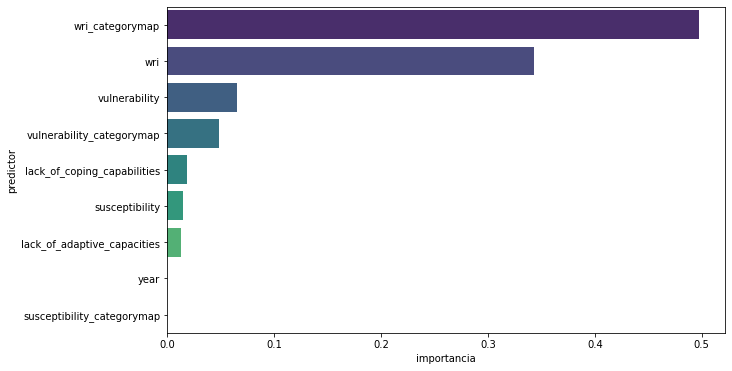

In [40]:
#Representamos de nuevo la importancia de las variables
plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores_2, palette="viridis");
plt.show()

Podemos ver como las variables con más importancia en nuestro arbol son la categoría de wri y wri, algo que tiene sentido ya que la variable exposure probablemente sea un cálculo relacionado con esta variable